<a href="https://colab.research.google.com/github/Jamesf50/UCDPA_JamesMcCaghey/blob/main/prem_league_21_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import re

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split ,TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
import warnings
warnings.filterwarnings("ignore")

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
file_path = '/content/drive/MyDrive/soccer21-22.csv'  # Replace 'filename.xlsx' with the actual file name and path
df = pd.read_csv(file_path)
print(df.head())


         Date    HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  13/08/2021   Brentford         Arsenal     2     0   H     1     0   H   
1  14/08/2021  Man United           Leeds     5     1   H     1     0   H   
2  14/08/2021     Burnley        Brighton     1     2   A     1     0   H   
3  14/08/2021     Chelsea  Crystal Palace     3     0   H     2     0   H   
4  14/08/2021     Everton     Southampton     3     1   H     0     1   A   

     Referee  ...  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0   M Oliver  ...    3    4  12   8   2   5   0   0   0   0  
1  P Tierney  ...    8    3  11   9   5   4   1   2   0   0  
2    D Coote  ...    3    8  10   7   7   6   2   1   0   0  
3     J Moss  ...    6    1  15  11   5   2   0   0   0   0  
4   A Madley  ...    6    3  13  15   6   8   2   0   0   0  

[5 rows x 22 columns]


In [149]:
df.info

<bound method DataFrame.info of            Date        HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0    13/08/2021       Brentford         Arsenal     2     0   H     1     0   
1    14/08/2021      Man United           Leeds     5     1   H     1     0   
2    14/08/2021         Burnley        Brighton     1     2   A     1     0   
3    14/08/2021         Chelsea  Crystal Palace     3     0   H     2     0   
4    14/08/2021         Everton     Southampton     3     1   H     0     1   
..          ...             ...             ...   ...   ...  ..   ...   ...   
375  22/05/2022  Crystal Palace      Man United     1     0   H     1     0   
376  22/05/2022       Leicester     Southampton     4     1   H     0     0   
377  22/05/2022       Liverpool          Wolves     3     1   H     1     1   
378  22/05/2022        Man City     Aston Villa     3     2   H     0     1   
379  22/05/2022         Norwich       Tottenham     0     5   A     0     2   

    HTR     Referee

In [150]:
def contains_special_char(value):
  return bool(re.search(r"[^\w\s\.\-]", value))

validity_check = df.astype('string')

mask= validity_check.applymap(contains_special_char)

result = validity_check[mask.any(axis=1)]

result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      380 non-null    string
 1   HomeTeam  380 non-null    string
 2   AwayTeam  380 non-null    string
 3   FTHG      380 non-null    string
 4   FTAG      380 non-null    string
 5   FTR       380 non-null    string
 6   HTHG      380 non-null    string
 7   HTAG      380 non-null    string
 8   HTR       380 non-null    string
 9   Referee   380 non-null    string
 10  HS        380 non-null    string
 11  AS        380 non-null    string
 12  HST       380 non-null    string
 13  AST       380 non-null    string
 14  HF        380 non-null    string
 15  AF        380 non-null    string
 16  HC        380 non-null    string
 17  AC        380 non-null    string
 18  HY        380 non-null    string
 19  AY        380 non-null    string
 20  HR        380 non-null    string
 21  AR        380 no

In [151]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [152]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.week

In [153]:
df.drop('year', inplace=True, axis=1)

In [154]:
df.isnull().sum()

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
Referee     0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
month       0
week        0
dtype: int64

In [155]:
df.Referee.unique()

array(['M Oliver', 'P Tierney', 'D Coote', 'J Moss', 'A Madley',
       'C Pawson', 'M Dean', 'A Marriner', 'M Atkinson', 'A Taylor',
       'D England', 'G Scott', 'S Attwell', 'P Bankes', 'R Jones',
       'K Friend', 'C Kavanagh', 'J Gillett', 'S Hooper', 'M Salisbury',
       'J Brooks', 'T Harrington'], dtype=object)

In [156]:
df.HomeTeam.unique()

array(['Brentford', 'Man United', 'Burnley', 'Chelsea', 'Everton',
       'Leicester', 'Watford', 'Norwich', 'Newcastle', 'Tottenham',
       'Liverpool', 'Aston Villa', 'Crystal Palace', 'Leeds', 'Man City',
       'Brighton', 'Southampton', 'Wolves', 'Arsenal', 'West Ham'],
      dtype=object)

In [157]:
df.AwayTeam.unique()

array(['Arsenal', 'Leeds', 'Brighton', 'Crystal Palace', 'Southampton',
       'Wolves', 'Aston Villa', 'Liverpool', 'West Ham', 'Man City',
       'Burnley', 'Newcastle', 'Brentford', 'Everton', 'Norwich',
       'Watford', 'Man United', 'Tottenham', 'Chelsea', 'Leicester'],
      dtype=object)

In [158]:
df.shape

(380, 24)

In [159]:
no_of_teams = 20
home_and_away = 2
no_of_matches_per_week = no_of_teams/2
number_of_matches = home_and_away*(no_of_teams-1)*no_of_matches_per_week
number_of_matches == df.shape[0]

True

In [160]:
df.Referee.value_counts()

A Taylor        28
P Tierney       27
M Oliver        26
C Pawson        26
M Dean          26
M Atkinson      26
J Moss          25
D Coote         20
S Attwell       20
A Marriner      19
K Friend        18
C Kavanagh      18
A Madley        16
D England       15
S Hooper        15
G Scott         12
R Jones         12
P Bankes        12
J Gillett        9
J Brooks         4
M Salisbury      3
T Harrington     3
Name: Referee, dtype: int64

In [161]:
df.HomeTeam.value_counts()

Brentford         19
Man United        19
Arsenal           19
Wolves            19
Southampton       19
Brighton          19
Man City          19
Leeds             19
Crystal Palace    19
Aston Villa       19
Liverpool         19
Tottenham         19
Newcastle         19
Norwich           19
Watford           19
Leicester         19
Everton           19
Chelsea           19
Burnley           19
West Ham          19
Name: HomeTeam, dtype: int64

In [162]:
df.AwayTeam.value_counts()

Arsenal           19
Leeds             19
Chelsea           19
Tottenham         19
Man United        19
Watford           19
Norwich           19
Everton           19
Brentford         19
Newcastle         19
Burnley           19
Man City          19
West Ham          19
Liverpool         19
Aston Villa       19
Wolves            19
Southampton       19
Crystal Palace    19
Brighton          19
Leicester         19
Name: AwayTeam, dtype: int64

the data is clean

In [163]:
referees = pd.DataFrame(list(df.Referee.unique()),columns = ['Referee'])
referees

,Referee
0,M Oliver
1,P Tierney
2,D Coote
3,J Moss
4,A Madley
5,C Pawson
6,M Dean
7,A Marriner
8,M Atkinson
9,A Taylor


In [164]:
table = pd.DataFrame(list(df.HomeTeam.unique()),columns = ['Team'])
table

,Team
0,Brentford
1,Man United
2,Burnley
3,Chelsea
4,Everton
5,Leicester
6,Watford
7,Norwich
8,Newcastle
9,Tottenham


In [165]:
shot_conv = pd.DataFrame(list(df.HomeTeam.unique()), columns = ['Team'])
shot_conv

,Team
0,Brentford
1,Man United
2,Burnley
3,Chelsea
4,Everton
5,Leicester
6,Watford
7,Norwich
8,Newcastle
9,Tottenham


In [166]:
referees[['played', 'home fouls', 'away fouls', 'home cards', 'away cards', 'home yellow', 'away yellow','home red', 'away red', 'home win', 'away win', 'draw']]=0

In [167]:
referees

,Referee,played,home fouls,away fouls,home cards,away cards,home yellow,away yellow,home red,away red,home win,away win,draw
0,M Oliver,0,0,0,0,0,0,0,0,0,0,0,0
1,P Tierney,0,0,0,0,0,0,0,0,0,0,0,0
2,D Coote,0,0,0,0,0,0,0,0,0,0,0,0
3,J Moss,0,0,0,0,0,0,0,0,0,0,0,0
4,A Madley,0,0,0,0,0,0,0,0,0,0,0,0
5,C Pawson,0,0,0,0,0,0,0,0,0,0,0,0
6,M Dean,0,0,0,0,0,0,0,0,0,0,0,0
7,A Marriner,0,0,0,0,0,0,0,0,0,0,0,0
8,M Atkinson,0,0,0,0,0,0,0,0,0,0,0,0
9,A Taylor,0,0,0,0,0,0,0,0,0,0,0,0


In [168]:
table[['played', 'win', 'draw', 'loss', 'gf', 'ga', 'gd', 'points', 'fouls']]=0

In [169]:
shot_conv[['shots','shots on target', 'conversion rate of target shots %', 'gf']]=0

In [170]:
table

,Team,played,win,draw,loss,gf,ga,gd,points,fouls
0,Brentford,0,0,0,0,0,0,0,0,0
1,Man United,0,0,0,0,0,0,0,0,0
2,Burnley,0,0,0,0,0,0,0,0,0
3,Chelsea,0,0,0,0,0,0,0,0,0
4,Everton,0,0,0,0,0,0,0,0,0
5,Leicester,0,0,0,0,0,0,0,0,0
6,Watford,0,0,0,0,0,0,0,0,0
7,Norwich,0,0,0,0,0,0,0,0,0
8,Newcastle,0,0,0,0,0,0,0,0,0
9,Tottenham,0,0,0,0,0,0,0,0,0


In [171]:
referees = referees.set_index('Referee')

In [172]:
table = table.set_index('Team')

In [173]:
shot_conv = shot_conv.set_index('Team')

In [174]:
table.head()

,played,win,draw,loss,gf,ga,gd,points,fouls
Team,,,,,,,,,
Brentford,0,0,0,0,0,0,0,0,0
Man United,0,0,0,0,0,0,0,0,0
Burnley,0,0,0,0,0,0,0,0,0
Chelsea,0,0,0,0,0,0,0,0,0
Everton,0,0,0,0,0,0,0,0,0


In [175]:
referees.head()

,played,home fouls,away fouls,home cards,away cards,home yellow,away yellow,home red,away red,home win,away win,draw
Referee,,,,,,,,,,,,
M Oliver,0,0,0,0,0,0,0,0,0,0,0,0
P Tierney,0,0,0,0,0,0,0,0,0,0,0,0
D Coote,0,0,0,0,0,0,0,0,0,0,0,0
J Moss,0,0,0,0,0,0,0,0,0,0,0,0
A Madley,0,0,0,0,0,0,0,0,0,0,0,0


In [176]:
for i in df.index:

  referee = df.Referee.loc[i]
  referees.loc[referee, 'played'] +=1
  referees.loc[referee, 'home fouls'] += df.HF.loc[i]
  referees.loc[referee, 'away fouls'] += df.AF.loc[i]
  referees.loc[referee, 'home yellow'] += df.HY.loc[i]
  referees.loc[referee, 'away yellow'] += df.AY.loc[i]
  referees.loc[referee, 'home red'] += df.HR.loc[i]
  referees.loc[referee, 'away red'] += df.AR.loc[i]

  if df.loc[i, 'FTR'] == "H":
        referees.loc[referee, 'home win'] += 1
  elif df.loc[i, 'FTR'] == "A":
        referees.loc[referee, 'away win'] += 1

  else:
      referees.loc[referee, 'draw'] += 1


referees['home cards'] = referees['home yellow'] + referees['home red']
referees['away cards'] = referees['away yellow'] + referees['away red']
referees['home win %'] = (referees['home win'] / referees['played']) *100
referees['away win %'] = (referees['away win'] / referees['played']) *100
referees['draw %'] = (referees['draw'] / referees['played']) *100






In [177]:
referees

,played,home fouls,away fouls,home cards,away cards,home yellow,away yellow,home red,away red,home win,away win,draw,home win %,away win %,draw %
Referee,,,,,,,,,,,,,,,
M Oliver,26,257,294,39,41,36,37,3,4,14,7,5,53.85,26.92,19.23
P Tierney,27,276,307,55,53,54,49,1,4,10,10,7,37.04,37.04,25.93
D Coote,20,221,255,44,48,43,47,1,1,5,8,7,25.00,40.00,35.00
J Moss,25,223,225,29,33,29,29,0,4,16,6,3,64.00,24.00,12.00
A Madley,16,186,189,16,22,16,20,0,2,10,4,2,62.50,25.00,12.50
C Pawson,26,310,266,53,56,51,56,2,0,13,9,4,50.00,34.62,15.38
M Dean,26,249,252,45,39,43,39,2,0,9,9,8,34.62,34.62,30.77
A Marriner,19,180,185,29,34,27,34,2,0,5,11,3,26.32,57.89,15.79
M Atkinson,26,182,224,32,34,32,32,0,2,14,8,4,53.85,30.77,15.38


In [178]:
for i in df.index:
    home = df.HomeTeam.loc[i]
    away = df.AwayTeam.loc[i]
    table.loc[home, 'played'] += 1
    table.loc[away, 'played'] += 1
    table.loc[home, 'gf'] += df.FTHG.loc[i]
    table.loc[away, 'gf'] += df.FTAG.loc[i]
    table.loc[home, 'ga'] += df.FTAG.loc[i]
    table.loc[away, 'ga'] += df.FTHG.loc[i]
    table.loc[home, 'fouls'] += df.HF.loc[i]
    table.loc[away, 'fouls'] += df.AF.loc[i]


    if df.loc[i, 'FTR'] == "H":
        table.loc[home, 'win'] += 1
        table.loc[away, 'loss'] += 1
    elif df.loc[i, 'FTR'] == "A":
        table.loc[away, 'win'] += 1
        table.loc[home, 'loss'] += 1
    else:
        table.loc[away, 'draw'] += 1
        table.loc[home, 'draw'] += 1

table['points'] = 3 * table['win'] + table['draw']
table['gd'] = table['gf'] - table['ga']
table['fouls'] = table['fouls'] + table['fouls']

In [179]:
table.head()

,played,win,draw,loss,gf,ga,gd,points,fouls
Team,,,,,,,,,
Brentford,38,13,7,18,48,56,-8,46,742
Man United,38,16,10,12,57,57,0,58,790
Burnley,38,7,14,17,34,53,-19,35,788
Chelsea,38,21,11,6,76,33,43,74,818
Everton,38,11,6,21,43,66,-23,39,736


In [180]:
for i in df.index:
    home = df.HomeTeam.loc[i]
    away = df.AwayTeam.loc[i]

    shot_conv.loc[home, 'shots'] += df.HS.loc[i]
    shot_conv.loc[away, 'shots'] += df.AS.loc[i]
    shot_conv.loc[home, 'shots on target'] += df.HST.loc[i]
    shot_conv.loc[away, 'shots on target'] += df.AST.loc[i]
    shot_conv.loc[home, 'gf'] += df.FTHG.loc[i]
    shot_conv.loc[away, 'gf'] += df.FTAG.loc[i]

shot_conv['conversion rate of target shots %'] = (shot_conv['gf'] / shot_conv['shots on target'])*100



In [181]:
shot_conv.head()

,shots,shots on target,conversion rate of target shots %,gf
Team,,,,
Brentford,442,154,31.17,48
Man United,508,187,30.48,57
Burnley,407,125,27.20,34
Chelsea,592,211,36.02,76
Everton,438,138,31.16,43


In [182]:
referees = referees.sort_values(by='played', ascending = False)
referees = referees.reset_index()

In [183]:
table = table.sort_values(by='points', ascending=False)
table = table.reset_index()

In [184]:
table

,Team,played,win,draw,loss,gf,ga,gd,points,fouls
0,Man City,38,29,6,3,99,26,73,93,640
1,Liverpool,38,28,8,2,94,26,68,92,726
2,Chelsea,38,21,11,6,76,33,43,74,818
3,Tottenham,38,22,5,11,69,40,29,71,772
4,Arsenal,38,22,3,13,61,48,13,69,726
5,Man United,38,16,10,12,57,57,0,58,790
6,West Ham,38,16,8,14,60,51,9,56,648
7,Leicester,38,14,10,14,62,59,3,52,712
8,Brighton,38,12,15,11,42,44,-2,51,786
9,Wolves,38,15,6,17,38,43,-5,51,730


joining the 2 tables specifying the columns.

In [185]:
table = table.merge(shot_conv, left_on=['Team', 'gf'],right_on=['Team','gf'])
table

,Team,played,win,draw,loss,gf,ga,gd,points,fouls,shots,shots on target,conversion rate of target shots %
0,Man City,38,29,6,3,99,26,73,93,640,715,254,38.98
1,Liverpool,38,28,8,2,94,26,68,92,726,730,256,36.72
2,Chelsea,38,21,11,6,76,33,43,74,818,592,211,36.02
3,Tottenham,38,22,5,11,69,40,29,71,772,491,198,34.85
4,Arsenal,38,22,3,13,61,48,13,69,726,588,197,30.96
5,Man United,38,16,10,12,57,57,0,58,790,508,187,30.48
6,West Ham,38,16,8,14,60,51,9,56,648,433,158,37.97
7,Leicester,38,14,10,14,62,59,3,52,712,435,169,36.69
8,Brighton,38,12,15,11,42,44,-2,51,786,490,152,27.63
9,Wolves,38,15,6,17,38,43,-5,51,730,402,136,27.94


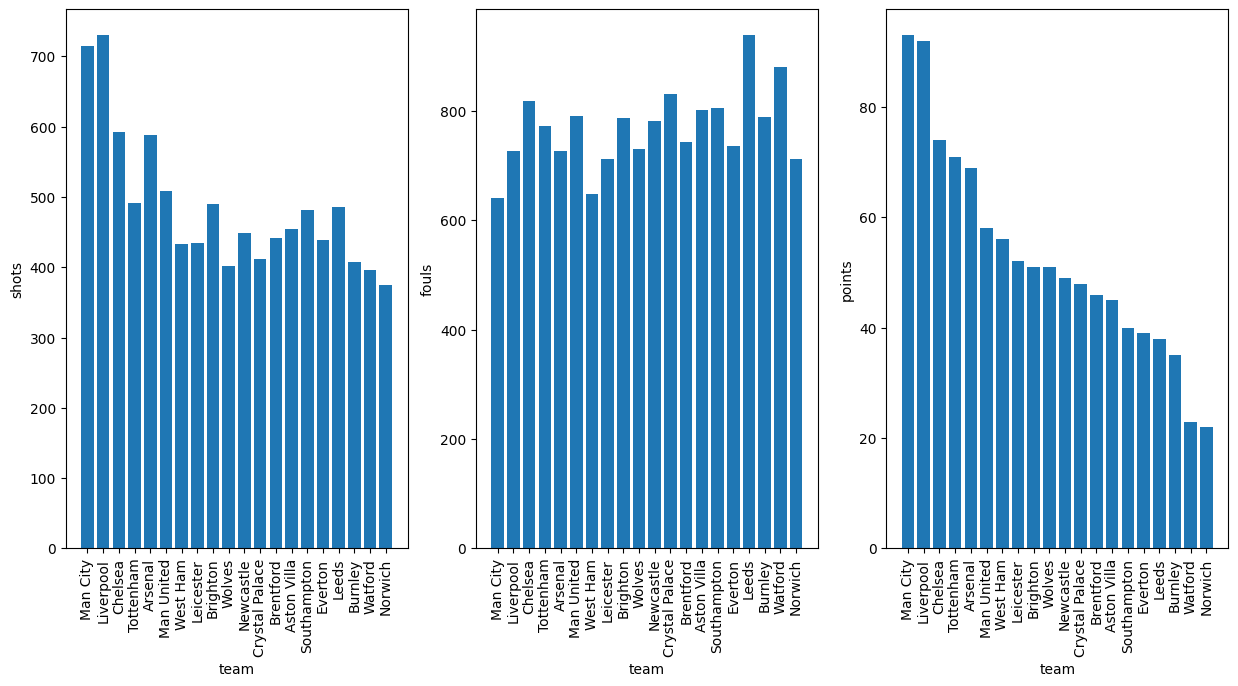

In [186]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.subplot(131)
plt.bar(table.Team, table.shots)
plt.xlabel('team')
plt.ylabel('shots')
plt.xticks(rotation='vertical')
plt.subplot(132)
plt.bar(table.Team, table.fouls)
plt.xlabel('team')
plt.ylabel('fouls')
plt.xticks(rotation='vertical')
plt.subplot(133)
plt.bar(table.Team, table.points)
plt.xlabel('team')
plt.ylabel('points')
plt.xticks(rotation='vertical')
plt.show()

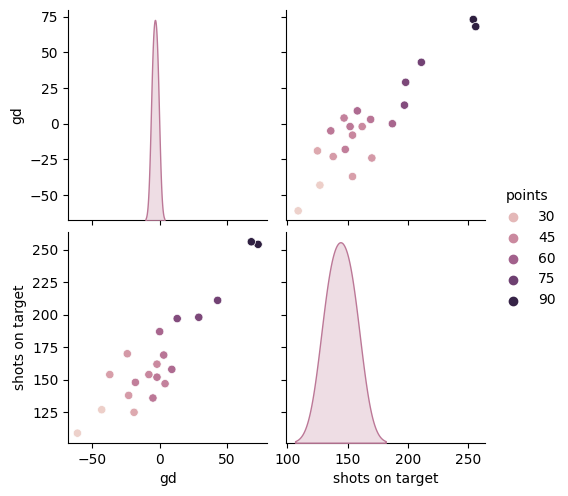

In [187]:
sns.pairplot(data=table, vars=['gd','shots on target'], hue = 'points')

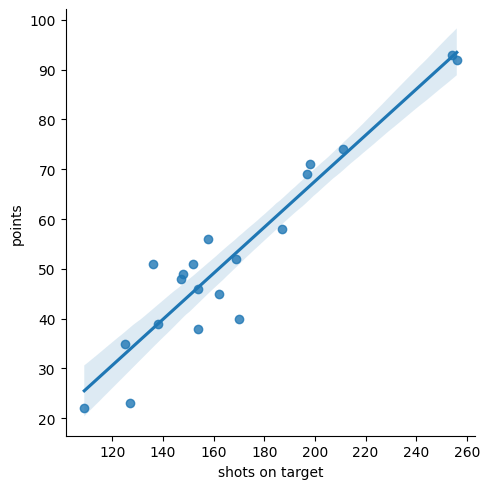

In [188]:
sns.lmplot(data=table, x='shots on target', y='points');

<Axes: >

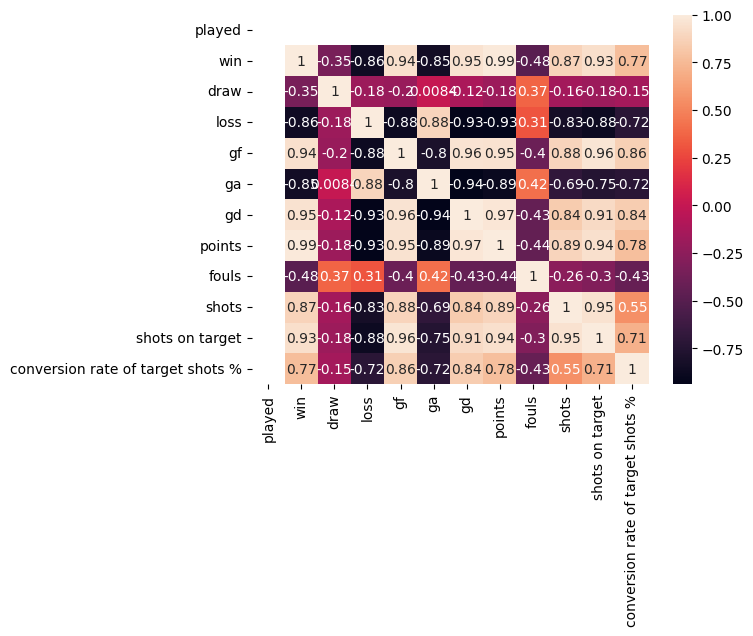

In [189]:
sns.heatmap(data=table.corr(), annot=True)

strong correlation between gd & win

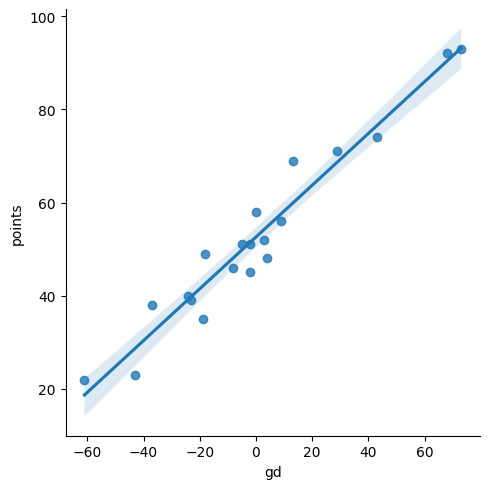

In [190]:
sns.lmplot(data=table, x='gd', y='points')

In [191]:
X=table[['gd']]
y=table['points']

In [192]:
reg = LinearRegression().fit(X,y)

In [193]:
reg.predict([[27]])

array([67.59875828])

In [194]:
def points(gd):
  gd_arr = np.array([[gd]])
  return round(reg.predict(gd_arr)[0])

In [195]:
points(-45)

28

In [196]:
reg.score(X,y)

0.9436350405003232

our model has an impressive score of .943 lets see can we improve it by adding in the extra feature to try and help our model

*   shots
*   fouls

In [197]:
X=table[['gd','fouls','shots on target']]
y=table['points']

In [198]:
reg = LinearRegression().fit(X,y)

In [199]:
reg.score(X,y)

0.9663608734475778

note that linear regression has no hyperparameters that can be tuned. also boosting which is the an ensemble model by combinging several weak decision trees sequentially, is not needed in this model either.

In [200]:
def points(gd,fouls,shotsontarget):
  points_arr = np.array([[gd,fouls,shotsontarget]])
  return round(reg.predict(points_arr)[0])

West Ham example +9gd, 648 fouls, 158 shots on target

In [201]:
points(9,648,158)

56

the model is pretty accurate with a score of .96.
now we can say that the factors that play the biggest part in the resulting points a team gets is 1) goal difference, 2)fouls they commit, 3)total shots across the season.

In [202]:
print(reg.coef_)

[ 0.34077371 -0.01887943  0.1852642 ]


result explained:
gd: 0.34
fouls: -0.018
shots on target: 0.18

these values tell us that if goal difference increases by 1 the points incrase by 0.34


now that we have the three main factors of obtaining points lets see how a team can use these to change players in thier team to get more points.

using Arsenal as an example

In [203]:
outside_player = pd.DataFrame({"Name": ['Luis Diaz', 'Jarrod Bowen'], "shot p/s":[86,67], "SoT p/s":[27,23],"conv %":[32,34], "fouls":[20,21], "gd":[8,7]})
outside_player

,Name,shot p/s,SoT p/s,conv %,fouls,gd
0,Luis Diaz,86,27,32,20,8
1,Jarrod Bowen,67,23,34,21,7


In [204]:
Ars_player = pd.DataFrame({"Name": ['Reiss Nelson', 'Mohamed Elneny'], "shot p/s":[26,28], "SoT p/s":[11,4],"conv %":[41,17], "fouls":[20,17], "gd":[4,1]})
Ars_player

,Name,shot p/s,SoT p/s,conv %,fouls,gd
0,Reiss Nelson,26,11,41,20,4
1,Mohamed Elneny,28,4,17,17,1


[link text](https://https://www.premierleague.com/players)the first dataframe is of players that don't play for Arsenal and then the dataframe is of two players that do play for Arsenal. the stats are per season, 'p/s, so effectively thier stats contribute to the overal team stats.
lets look at what would happen to Arsenals points if they where to swap Trossard and Pepe for Diaz and Bowen.

In [205]:
shot_change  = sum(outside_player['shot p/s']-Ars_player['shot p/s'])
print('shots p/s change: '+ str(shot_change))

sot_change = sum(outside_player['SoT p/s']-Ars_player['SoT p/s'])
print('shots on target p/s change: '+ str(sot_change))

foul_change = sum(outside_player['fouls']-Ars_player['fouls'])
print('fouls p/s change: ' + str(foul_change))

gd_change = sum((outside_player['gd']-Ars_player['gd']))
print('goal difference p/s change: ' + str(gd_change))



shots p/s change: 99
shots on target p/s change: 35
fouls p/s change: 4
goal difference p/s change: 10


In [206]:
table.iloc[4]

Team                                 Arsenal
played                                    38
win                                       22
draw                                       3
loss                                      13
gf                                        61
ga                                        48
gd                                        13
points                                    69
fouls                                    726
shots                                    588
shots on target                          197
conversion rate of target shots %      30.96
Name: 4, dtype: object

with two new player team stats:
gd 23
fouls 730
shots on target 232

In [207]:
points(23,730,232)

73

By changing 1 midfielder and 1 forward in their team Arsenal could get 73 points in the season which would take them above Totenham and into a top 4 finish where they get rewarded with being in the European champions league, only the top for teams from England get a chance to play in this competition. Reaching this competition results in £15 million bonus for the club in prize money along with £2.8 million for every game they win in the competition.

!!!!! More Insight !!!!!!

In [208]:
referees.iloc[2]

Referee        M Oliver
played               26
home fouls          257
away fouls          294
home cards           39
away cards           41
home yellow          36
away yellow          37
home red              3
away red              4
home win             14
away win              7
draw                  5
home win %        53.85
away win %        26.92
draw %            19.23
Name: 2, dtype: object

looking at the table we can see from M Oliver row that 53.85% of his games have finished in home wins. If we where to place a bet on his game on 19/08/2023, Tottenham vs Man united. We can bet on home win with draw no bet meaning that if the game ends in a draw we get our money back. This leaves us with only a 26% chance of losing our money.
The odds on this where 15/8 or 1.875, so £10 on gets you £8.75.  

In [209]:
bet_table = pd.DataFrame(list(df.HomeTeam.unique()),columns = ['Team'])
bet_table.head()


,Team
0,Brentford
1,Man United
2,Burnley
3,Chelsea
4,Everton


In [210]:
bet_table[['gf', 'ga', 'shots', 'shots on target', 'yellow']]=0

In [211]:
bet_table = bet_table.set_index('Team')

In [212]:
for i in df.index:
    home = df.HomeTeam.loc[i]
    away = df.AwayTeam.loc[i]

    bet_table.loc[home, 'gf'] += df.FTHG.loc[i]
    bet_table.loc[away, 'gf'] += df.FTAG.loc[i]
    bet_table.loc[home, 'ga'] += df.FTAG.loc[i]
    bet_table.loc[away, 'ga'] += df.FTHG.loc[i]
    bet_table.loc[home, 'shots'] += df.HS.loc[i]
    bet_table.loc[away, 'shots'] += df.AS.loc[i]
    bet_table.loc[home, 'shots on target'] += df.HST.loc[i]
    bet_table.loc[away, 'shots on target'] += df.AST.loc[i]
    bet_table.loc[home, 'yellow'] += df.HY.loc[i]
    bet_table.loc[away, 'yellow'] += df.AY.loc[i]





bet_table['gf'] = bet_table['gf']/38
bet_table['ga'] = bet_table['ga']/38
bet_table['shots'] = bet_table['shots']/38
bet_table['shots on target'] = bet_table['shots on target']/38
bet_table['yellow'] = bet_table['yellow']/38










In [213]:
bet_table

,gf,ga,shots,shots on target,yellow
Team,,,,,
Brentford,1.26,1.47,11.63,4.05,1.61
Man United,1.50,1.50,13.37,4.92,1.97
Burnley,0.89,1.39,10.71,3.29,1.79
Chelsea,2.00,0.87,15.58,5.55,1.66
Everton,1.13,1.74,11.53,3.63,2.00
Leicester,1.63,1.55,11.45,4.45,1.42
Watford,0.89,2.03,10.42,3.34,1.50
Norwich,0.61,2.21,9.84,2.87,1.45
Newcastle,1.16,1.63,11.79,3.89,2.08


West Ham vs Chelsea 20/08/2023
Running off our table we can bet on team shots, with chelsea avg 16 we can bet on over 12.5 shots at 4/9 or 0.44
West ham shots over 9.5 4/9 or 0.44

shots on traget home over 2.5 shots on target 1/4 or 0.25
away shots on target over 4.5 shots on target 3/4 or 0.75


match shots over 23.5 8/15 or 0.53
match shots on target over 8.5 5/6 or 0.83

total goals over 1.5 2/9 or 0.22

